In [17]:
# Understanding the error surface
#All imports
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import collections

########################################
#Generate meaningful data
########################################

# Generate 25 heights in inches
heights = np.linspace(52.5, 77.5, 25)
X = np.column_stack((np.ones(len(heights)), heights))  # shape (25, 2)

w_vec = np.array([-100.42, 3.86])

# Define the weight function
def wt(X,w_vec):
    return X @ w_vec  # h in inches, w in pounds

# Calculate weights
weights = wt(X,w_vec)

# Noise parameters
mean = 0
variance = 20
std_dev = np.sqrt(variance)

# Generate Gaussian noise
np.random.seed(0)
noise = np.random.normal(mean, std_dev, size=heights.shape)

# Add noise to original data
noisy_weights = weights + noise

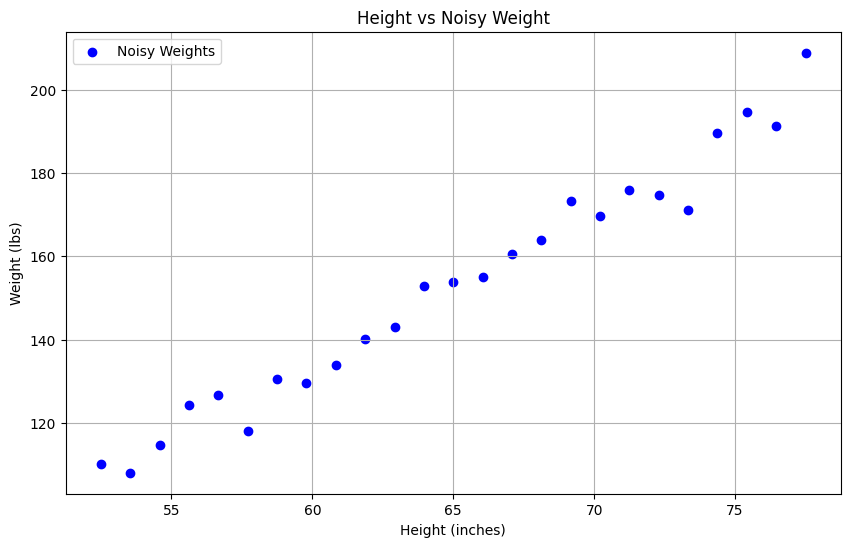

In [18]:
########################################
#Plot scatter plot of data
########################################

plt.figure(figsize=(10, 6))
plt.scatter(heights, noisy_weights, color='blue', label='Noisy Weights')
plt.xlabel('Height (inches)')
plt.ylabel('Weight (lbs)')
plt.title('Height vs Noisy Weight')
plt.legend()
plt.grid(True)
plt.show()

### Height vs Noisy Weight Scatter Plot

 Due to the added noise, the points do not lie exactly on a straight line, they are scattered around the expected linear trend.

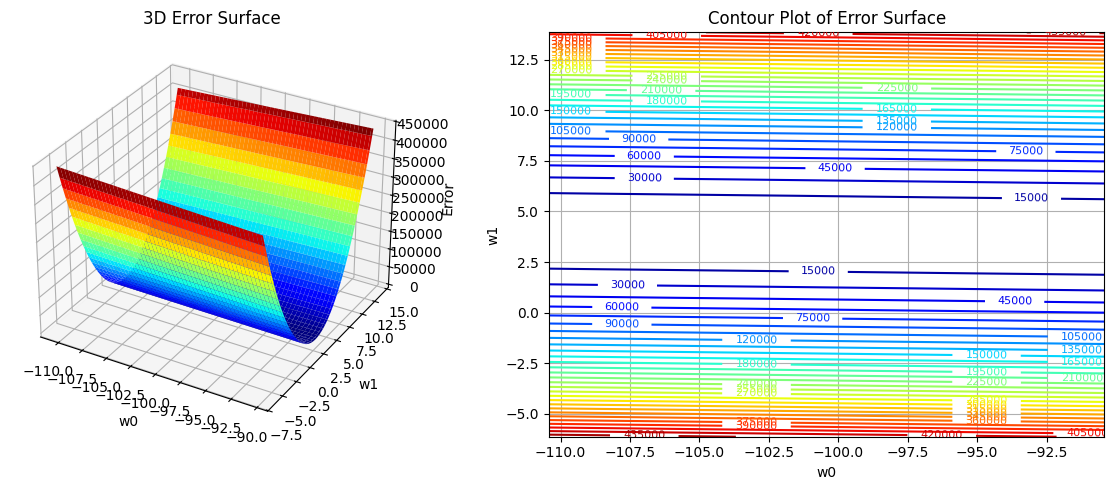

In [19]:
########################################
#Weight estimation through error surface, i.e., empirically locate the minima of error surface
########################################

# Known weights
w0_center = -100.42
w1_center = 3.86

# Define a range around the known weights
w0_range = np.linspace(w0_center - 10, w0_center + 10, 100) 
w1_range = np.linspace(w1_center - 10, w1_center + 10, 100)

#Compute the error
def Error(w,t,x): #inputs : 1)weight 2)data i.e (t = target,x = input)
    y_pred = x @ w
    error = np.mean((t - y_pred)**2)
    return error

errors = np.zeros((len(w0_range), len(w1_range)))
for i, w0 in enumerate(w0_range):
    for j, w1 in enumerate(w1_range):
        w = np.array([w0, w1])
        errors[i, j] = Error(w, noisy_weights, X)

# Plotting the 3D error surface
W0, W1 = np.meshgrid(w0_range, w1_range)
fig = plt.figure(figsize=(12, 5))

# --- 3D Error Surface ---
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(W0, W1, errors.T, cmap='jet')
ax1.set_title('3D Error Surface')
ax1.set_xlabel('w0')
ax1.set_ylabel('w1')
ax1.set_zlabel('Error')

# --- Contour Plot ---
ax2 = fig.add_subplot(1, 2, 2)
contour = ax2.contour(W0, W1, errors.T, levels=30, cmap='jet')
ax2.clabel(contour, inline=True, fontsize=8)
ax2.set_title('Contour Plot of Error Surface')
ax2.set_xlabel('w0')
ax2.set_ylabel('w1')
ax2.grid(True)

plt.tight_layout()
plt.show()


### 3D Error Surface
- This 3D plot shows how the error changes as we try out different values for the linear regression weights w0 (intercept) and w1 (slope).
- It forms a bowl-like shape, which is exactly what we expect — this tells us that there's one clear minimum where the error is the lowest.
- The colors help us see the difference in error: red means high error, and blue means low error. So the deepest part of the bowl is where the model fits best.
- This plot makes it easy to understand why gradient descent works so well here — we can "slide down" to the minimum.

### Contour plot
- This is the same error surface, but viewed from above.
- Each line (or contour) connects points with the same error value.

In [20]:
########################################
#Locate the minima of the error surface
########################################

# Find the indices of the minimum error
min_index = np.unravel_index(np.argmin(errors), errors.shape)

# Get corresponding w0 and w1 values
min_w0 = w0_range[min_index[0]]
min_w1 = w1_range[min_index[1]]

print(f"Minimum error found at:")
print(f"w0 (bias) = {min_w0}")
print(f"w1 (slope) = {min_w1}")

error_weights = np.array([min_w0,min_w1])
error_pred = X @ error_weights

Minimum error found at:
w0 (bias) = -91.6321212121212
w1 (slope) = 3.758989898989899


In [21]:
########################################
#Least squares approach to estimate the weights
########################################

def LinearRegression(X, t):  #inputs : 1)input data i.e (x). 2)target i.e (t)
    w_opt = np.linalg.inv(X.T @ X) @ X.T @ t
    return w_opt

# Estimate weights using normal equation
regression_weights = LinearRegression(X, noisy_weights)
regression_pred = X @ regression_weights

print("\nEstimated weights using least squares:")
print(f"w0 (bias) = {regression_weights[0]}")
print(f"w1 (slope) = {regression_weights[1]}")


Estimated weights using least squares:
w0 (bias) = -86.46847304843939
w1 (slope) = 3.6780540791086245


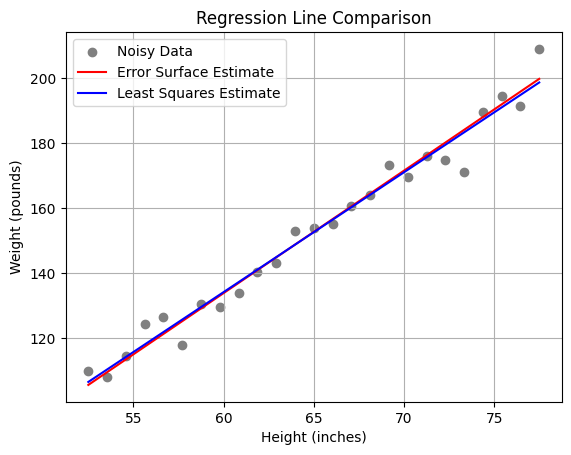

In [22]:
########################################
# Plot the estimated line on top of the above scatter plot
########################################

# Plot the noisy data
plt.scatter(heights, noisy_weights, label='Noisy Data', color='gray')

# Predicted lines
plt.plot(heights, error_pred, label='Error Surface Estimate', color='red')
plt.plot(heights, regression_pred, label='Least Squares Estimate', color='blue')

# Labels and legend
plt.xlabel("Height (inches)")
plt.ylabel("Weight (pounds)")
plt.title("Regression Line Comparison")
plt.legend()
plt.grid(True)
plt.show()

### Regression line comparison

- Both the red and blue lines fit the noisy data very closely, which shows that:
  - The error surface and least squares method both lead to very similar results.
  - This confirms that the error surface has a clear minimum and both methods are converging to it.
- There is only a slight visual difference between the two lines, likely due to:
  - The red method only looks at a limited number of weight combinations.
  - Floating-point math might introduce tiny inaccuracies, especially when working with very small or large numbers.


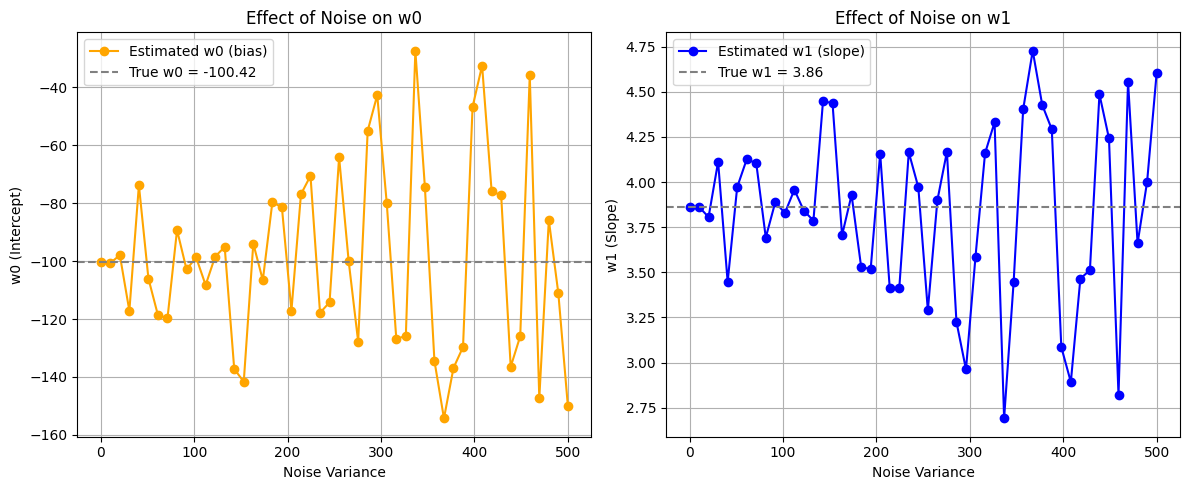

In [25]:
########################################
# Effect of variance
########################################

variances = variances = np.linspace(0, 500,50)  # 50 points from 0 to 500

w0_vals = []
w1_vals = []

for var in variances:
    noise_var = np.random.normal(0, np.sqrt(var), size=heights.shape)
    noisy_wt = weights + noise_var
    t_noisy = noisy_wt.reshape(-1, 1)
    w_est = LinearRegression(X,t_noisy)
    w0_vals.append(w_est[0])
    w1_vals.append(w_est[1])

# True values
true_w0 = -100.42
true_w1 = 3.86

# Plot w0
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(variances, w0_vals, 'o-', label='Estimated w0 (bias)', color='orange')
plt.axhline(true_w0, color='gray', linestyle='--', label=f'True w0 = {true_w0}')
plt.xlabel('Noise Variance')
plt.ylabel('w0 (Intercept)')
plt.title('Effect of Noise on w0')
plt.legend()
plt.grid(True)

# Plot w1
plt.subplot(1, 2, 2)
plt.plot(variances, w1_vals, 'o-', label='Estimated w1 (slope)', color='blue')
plt.axhline(true_w1, color='gray', linestyle='--', label=f'True w1 = {true_w1}')
plt.xlabel('Noise Variance')
plt.ylabel('w1 (Slope)')
plt.title('Effect of Noise on w1')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Effect of noise variance on w₀ and w₁
- Both the intercept and slope estimates get noisier and less stable as the noise in the data increases.
- Low-noise data leads to more reliable parameter estimation in linear regression.
- When Gaussian noise is added with mean 0, it doesn't push values in one fixed direction (e.g., always up or always down).
  Instead some values get pushed up, others pushed down, and this randomness affects the regression line.


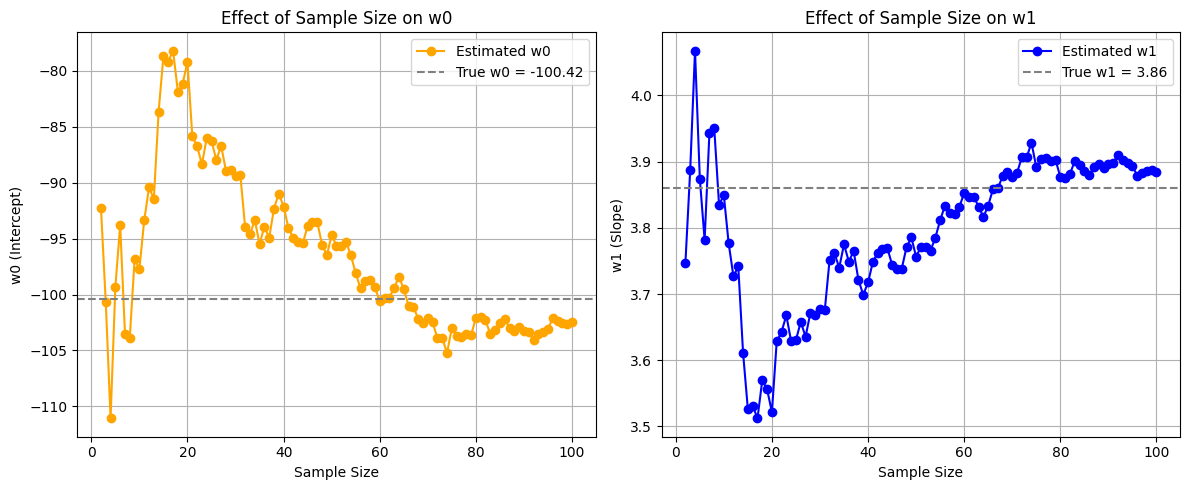

In [26]:
########################################
# Effect of sample size
########################################

sample_sizes = list(range(2, 101))  # From 1 to 100 inclusive
est_w0 = []
est_w1 = []
for N in sample_sizes:
    np.random.seed(42)  # Ensures reproducibility
    heights = np.linspace(52.5, 77.5, N)
    X = np.column_stack((np.ones(len(heights)), heights))
    true_weights = wt(X,w_vec)
    random_noise = np.random.normal(0, std_dev, size=heights.shape)
    noisy_weights = true_weights + random_noise

    # Perform linear regression
    t_noisy = noisy_weights.reshape(-1, 1)
    w_est = LinearRegression(X, t_noisy)
    est_w0.append(w_est[0])
    est_w1.append(w_est[1])

# Plotting the effect of sample size on w0 and w1
plt.figure(figsize=(12, 5))

# w0 plot
plt.subplot(1, 2, 1)
plt.plot(sample_sizes, est_w0, 'o-', label='Estimated w0', color='orange')
plt.axhline(w_vec[0], linestyle='--', color='gray', label='True w0 = -100.42')
plt.xlabel("Sample Size")
plt.ylabel("w0 (Intercept)")
plt.title("Effect of Sample Size on w0")
plt.grid(True)
plt.legend()

# w1 plot
plt.subplot(1, 2, 2)
plt.plot(sample_sizes, est_w1, 'o-', label='Estimated w1', color='blue')
plt.axhline(w_vec[1], linestyle='--', color='gray', label='True w1 = 3.86')
plt.xlabel("Sample Size")
plt.ylabel("w1 (Slope)")
plt.title("Effect of Sample Size on w1")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### Overfitting vs Underfitting

- With very small sample sizes, the model may overfit the noise in the data:
  - It tries too hard to fit every point, even the random fluctuations.
  - This causes high variance in w₀ and w₁.

- With larger sample sizes, the model captures the true underlying trend better:
  - It becomes less sensitive to noise and more generalizable.
  - This reduces the risk of both overfitting and underfitting.